# 20146703 박지호

## Assignment 7

input으로 image를 하나 선택, k-means algorithm을 적용. 클러스터의 수와 intensity energy와 spatial energy 사이의 trade-off 고려

object function은 다음과 같다

$$ \sum_k \sum_\{ x \in I(k) \} [ \| f(x) - m_k \|^2 + a * \| x - c_k \|^2 ] $$

l(k): cluster k에 속하는 x의 index set

m_k: cluster k에 대한 image intensity의 centroid

c_k: cluster k에 대한 spatial location의 centroid

a: image intensity와 spatial location 사이의 중요성을 결정

1. 클러스터링된 결과를 visualization하기 (k를 다양하게 해보기, 클러스터마다 centroid color를 이용해서

2. intensity energy graph와 spatial energy graph를 visualization하기

# Import python module

In [1]:
# module import 하기

import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time
from PIL import Image

# - spatial location function -

## inspect duplicate centroid

In [2]:
def inspect_duplicate_centroid_L2(centroid_x, centroid_y, cluster_num):
    while True:
        flag = 0
        flag_x = []
        flag_y = []
        for i in range(0, cluster_num):
            for j in range(i+1, cluster_num):
                if abs(centroid_x[i] - centroid_x[j]) <= 0.5:
                    flag_x.append([i,j])

        for i in range(0, cluster_num):
            for j in range(i+1, cluster_num):
                if abs(centroid_y[i] - centroid_y[j]) <= 0.5:
                    flag_y.append([i,j])

        for x in flag_x:
            for y in flag_y:
                if x == y:
                    centroid_x[x[0]] -= 0.5
                    centroid_y[y[0]] -= 0.65
                    flag -= 1
                else:
                    flag += 1
        
        size = len(flag_x) * len(flag_y)
        
        if flag == size:
            break

    return centroid_x, centroid_y

## L2_norm centroid

In [3]:
def cal_centroid_L2(x_matrix, y_matrix, data, numbers) : 
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    centroid_x = np.zeros(cluster_num)
    centroid_y = np.zeros(cluster_num)
    count = np.zeros(cluster_num)
    
    for i in range(row_num):
        for j in range(column_num):
            label = int(data[i][j])
            centroid_x[label] += x_matrix[i][j]
            centroid_y[label] += y_matrix[i][j]
            count[label] += 1

    centroid_x /= count
    centroid_y /= count
        
    centroid_x, centroid_y = inspect_duplicate_centroid_L2(centroid_x, centroid_y, cluster_num)
    return centroid_x, centroid_y

## L2_norm distance

In [4]:
def L2_distance(L2_centroid_x, L2_centroid_y, x_matrix, y_matrix, data, numbers):
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]

    energy=0
    
    for k in range(row_num):
        for j in range(column_num):
            L2_result = [0 for _ in range(cluster_num)]
            for i in range(cluster_num):
                L2_result[i] += pow(L2_centroid_x[i] - x_matrix[k][j], 2)
                L2_result[i] += pow(L2_centroid_y[i] - y_matrix[k][j] ,2)
            
            L2_result_arr = np.asfarray(L2_result[0:cluster_num])
            data[k][j] = L2_result_arr.argmin()
            energy += L2_result_arr.min()
    return energy, data

## Initialize random rable for spatial location

In [28]:
def init_variable_for_clustering_location(row_num, column_num, cluster_num):
    x = []
    y = []
    
    data = np.zeros((row_num, column_num), dtype='i')
    
    # initialize row matrix
    for i in range(row_num):
        temp = [i for _ in range(row_num)]
        x += temp
    
    # initialize column matrix
    column = []
    for i in range(column_num):
        temp = [i for _ in range(1)]
        column += temp
    
    for i in range(column_num):
        y += column
    
    return x, y

## update label using L2_norm for spatial location

In [6]:
def update_label_for_clustering_location(centroid_x, centroid_y, x_matrix, y_matrix, data, numbers):
    # calculate distance centroid to pixel
    # update new label
    energy, data = L2_distance(centroid_x, centroid_y, x_matrix, y_matrix, data, numbers)
    
    return energy, data

## clustering for spatial locaiton

In [8]:
def clustering_spatial_location(original_data, width, height, cluster_num):
    print("Start clustering for spatial location")
    # row의 개수와 column의 개수
    row_num = height
    column_num = width

    # stop learn clustering 
    max_clustering = 300 
    threshold = 0.0001

    # x : horizontal list
    # y : vertical list
    # data : initialized data ( random label )
    x, y = init_variable_for_clustering_location(row_num, column_num, cluster_num)

    x_array = np.asfarray(x[0:column_num*row_num])
    x_matrix = x_array.reshape((row_num, column_num))

    y_array = np.asfarray(y[0:column_num*row_num])
    y_matrix = y_array.reshape((row_num, column_num))

    
    max_cluster = 300
    
    prev_energy = 1000000
    energy = 0
    all_energy_L2 = []
    all_iteration_L2 = []
    cluster_count= 0
    
    
    numbers=[row_num, column_num, cluster_num]
    
    L2_data = original_data.copy()
    
    
    ###########################
    # clustering using L2_norm
    ###########################
    L2_centroid_x, L2_centroid_y = cal_centroid_L2(x_matrix, y_matrix, L2_data, numbers)
    
    while True:
        energy, L2_data = update_label_for_clustering_location(L2_centroid_x, L2_centroid_y, x_matrix, y_matrix, L2_data, numbers)
        energy /= row_num*column_num*cluster_num
        
        all_energy_L2.append(energy)
        all_iteration_L2.append(cluster_count)
        
        # energy의 차이가 아주 작아지면 clustering 멈추기
        if prev_energy <= energy*(1 + threshold):
            break
        elif cluster_count >= max_cluster :
            break
        else:
            prev_energy = energy
            cluster_count += 1
            energy = 0
            # update centroid
            L2_centroid_x, L2_centroid_y = cal_centroid_L2(x_matrix, y_matrix, L2_data, numbers)
        
        # debugging
        if cluster_count % 30 == 0:
            print("clustering: ", cluster_count)
   
    # match label and color code
    L2_mapped_color_data = match_label_and_color(L2_data, numbers)
    
    ############################
    ### plot image and graph
    ############################
    plt.figure(figsize=(7, 7))
    
    plt.subplot(2, 1, 1)
    plt.imshow(L2_mapped_color_data)
    plt.title('image using L2')
    

    plt.subplot(2,1, 2)
    plt.plot(all_iteration_L2, all_energy_L2)
    plt.title('energy graph using L2')

    
    # plot
    plt.show()

# image intensity function

## Random Labeling

In [21]:
def init_label(cluster_num, height, width):
    label = np.zeros((height, width))
    for k in range(0, height):
        for j in range(0, width):
            label[k][j] = int(random.randrange(0, cluster_num))
    
    return label

## Open image and read pixel data

In [10]:
def open_image(image_name):
    # load image
    im = Image.open('butterfly.jpg')
    
    # Fetch image pixel data to numpy array
    data = np.array(im)
    
    return data

## calculate centroid (clustering image intensity)

In [24]:
def cal_centroid(label, data, numbers):
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    clusters = np.zeros( (cluster_num, 3))
    label_count = np.zeros( cluster_num )
        
    for x in range(row_num):
        for y in range(column_num):
            image_label = int(label[x][y])
            clusters[image_label][0] += data[x][y][0]
            clusters[image_label][1] += data[x][y][1]
            clusters[image_label][2] += data[x][y][2]
            
            label_count[image_label] += 1
    
    for i in range(0, cluster_num):
        clusters[i] /= label_count[i]
    
    clusters = inspect_duplicate_centroid(clusters, cluster_num)
    return clusters

In [12]:
def inspect_duplicate_centroid(image_centroid, cluster_num):
    while True:
        flag = 0
        flag_list = []
        for i in range(0, cluster_num):
            for j in range(i+1, cluster_num):
                temp_list = []
                temp_list = abs(image_centroid[i] - image_centroid[j])

                if temp_list[0] <= 0.35:
                    flag_list.append([i,j])
                elif temp_list[1] <= 0.35:
                    flag_list.append([i,j])
                elif temp_list[2] <= 0.35:
                    flag_list.append([i,j])

        if len(flag_list) == 0:
            break
        else:
            for x in flag_list:
                image_centroid[x[0]] -= 0.2

    return image_centroid

In [13]:
# centroid와 pixel간의 distance 구하기
'''
def cal_distance(label, data, image_centroid, numbers):
    energy = 0
    
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    for k in range(row_num):
        for j in range(column_num):
            L2_result = [0 for _ in range(cluster_num)]
            for i in range(cluster_num):
                temp = [0 for _ in range(3)]
                temp_num = 0
                temp += pow(image_centroid[i] - data[k][j], 2)
                
                for num in temp:
                    temp_num += num
                    
                L2_result[i] += temp_num
                
            L2_result_arr = np.asfarray(L2_result[0:cluster_num])
            label[k][j] = L2_result_arr.argmin()
            energy += L2_result_arr.min()
    
    return label, energy
'''

'\ndef cal_distance(label, data, image_centroid, numbers):\n    energy = 0\n    \n    row_num = numbers[0]\n    column_num = numbers[1]\n    cluster_num = numbers[2]\n    \n    for k in range(row_num):\n        for j in range(column_num):\n            L2_result = [0 for _ in range(cluster_num)]\n            for i in range(cluster_num):\n                temp = [0 for _ in range(3)]\n                temp_num = 0\n                temp += pow(image_centroid[i] - data[k][j], 2)\n                \n                for num in temp:\n                    temp_num += num\n                    \n                L2_result[i] += temp_num\n                \n            L2_result_arr = np.asfarray(L2_result[0:cluster_num])\n            label[k][j] = L2_result_arr.argmin()\n            energy += L2_result_arr.min()\n    \n    return label, energy\n'

In [33]:
def make_clustered_data(image_centroid, label, height, width):
    clustered_data = np.zeros( (height, width, 3))
    
    for i in range(height):
        for j in range(width):
            # image의 라벨에 해당하는 centroid로 바꿔주기
            clustered_data[i][j][0] = int(image_centroid[int(label[i][j])][0]) # red
            clustered_data[i][j][1] = int(image_centroid[int(label[i][j])][1]) # green
            clustered_data[i][j][2] = int(image_centroid[int(label[i][j])][2]) # blue
    
    return clustered_data

## Plot image

In [34]:
def display_image(image):
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.imshow(image)

In [15]:
def update_label_for_clustering_intensity(label, data, image_centroid, numbers):
    label, energy = cal_distance(label, data, image_centroid, numbers)
    
    return label, energy

In [16]:
def distance_1(image_centroid, data):
    temp = [0 for _ in range(3)]
    distance = 0
    
    temp += pow(image_centroid - data, 2)

    for num in temp:
        distance += num
    return distance

In [17]:
def distance_2(centroid_x, centroid_y, x, y):
    distance = 0
    distance += pow(centroid_x - x, 2)
    distance += pow(centroid_y - y, 2)
    
    return distance

In [18]:
def temp_update(label, data, importance_degree, image_centroid, L2_centroid_x, L2_centroid_y, x_matrix, y_matrix, numbers):
    result = []
    location_distance = 0
    intensity_distance = 0
    energy = 0
    
    row_num = numbers[0]
    column_num = numbers[1]
    cluster_num = numbers[2]
    
    for k in range(row_num):
        for j in range(column_num):
            result = [0 for _ in range(cluster_num)]
            for i in range(cluster_num):
                intensity_distance = distance_1(image_centroid[i], data[k][j])
                intensity_distance /= row_num * column_num
                
                location_distance = distance_2(L2_centroid_x[i], L2_centroid_y[i], x_matrix[k][j], y_matrix[k][j])
                location_distance /= row_num*column_num*cluster_num
                
                result[i] = intensity_distance + importance_degree * location_distance
    
            result_arr = np.asfarray(result[0:cluster_num])
            label[k][j] = result_arr.argmin()
            energy += result_arr.min()

    return label, energy

In [39]:
def clustering(cluster_num, importance_degree):
    image_name = "butterfly.jpg"

    original_data = open_image(image_name)
    intensity_data = original_data.copy()
    
    image_shape = original_data.shape
    
    # size of image
    width = image_shape[0]
    height = image_shape[1]
    numbers=[height, width, cluster_num]
    
    # random label initialize
    label = init_label(cluster_num, height, width)
        
    # x : horizontal list
    # y : vertical list
    # data : initialized data ( random label )
    x, y = init_variable_for_clustering_location(height, width, cluster_num)

    x_array = np.asfarray(x[0:height*width])
    x_matrix = x_array.reshape((height, width))

    y_array = np.asfarray(y[0:height*width])
    y_matrix = y_array.reshape((height, width))
    
    
    #######################
    # initialize variable #
    #######################
    prev_energy = 1000000
    energy = 0
    all_energy = []
    all_iteration = []
    cluster_count = 0
    threshold = 0.0001
    max_cluster = 300
    

    #################################
    # calculate centroid each label #
    #################################
    image_centroid = cal_centroid(label, intensity_data, numbers)
    L2_centroid_x, L2_centroid_y = cal_centroid_L2(x_matrix, y_matrix, label, numbers)
    
    
    while(True):
        label, energy = temp_update(label, intensity_data, importance_degree, image_centroid, L2_centroid_x, L2_centroid_y, x_matrix, y_matrix, numbers)
        
        all_energy.append(energy)
        all_iteration.append(cluster_count)
        
        # energy의 차이가 아주 작아지면 clustering 멈추기
        if prev_energy <= energy*(1 + threshold):
            break
        elif cluster_count >= max_cluster :
            break
        
        else:
            image_centroid = cal_centroid(label, intensity_data, numbers)
            L2_centroid_x, L2_centroid_y = cal_centroid_L2(x_matrix, y_matrix, label, numbers)
            prev_energy = energy
            energy = 0
            cluster_count += 1
        
        # debugging
        if cluster_count % 10 == 0:
            print("clustering: ", cluster_count)
            
    clustered_data = make_clustered_data(image_centroid, label, height, width)

    # np.float64 -> np.uint8
    clustered_data = clustered_data.astype(np.uint8)

    # plot origin image
    display_image(original_data)

    # plot clustered image
    display_image(clustered_data)

    # plot enegy graph
    energy_graph = plt.figure("Energy Graph", figsize=(5,5))
    energy_graph.add_subplot(1,1,1).plot(all_iteration, all_energy)

    # plot
    plt.show()

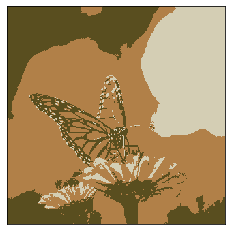

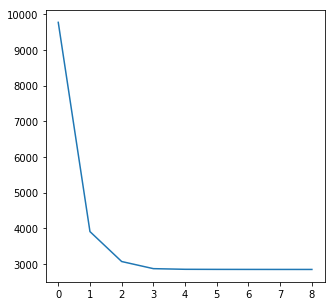

In [40]:
clustering(3, 0)

clustering:  10


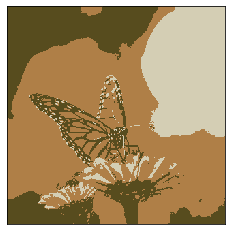

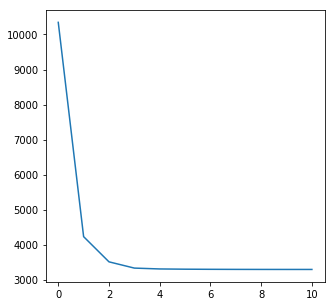

In [41]:
clustering(3, 0.1)

clustering:  10


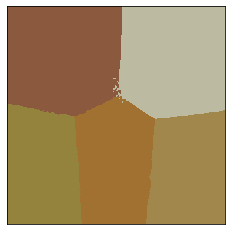

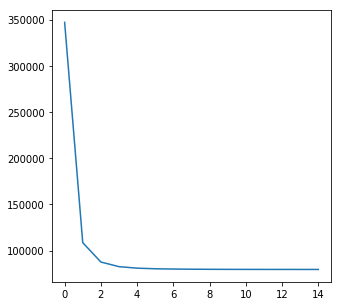

In [43]:
clustering(5, 100)

clustering:  10
clustering:  20
clustering:  30


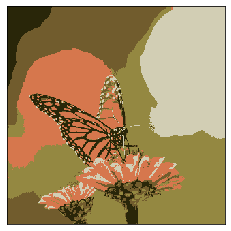

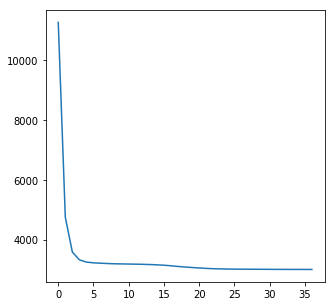

In [44]:
clustering(5, 0.5)